# Training 3D U-Net model for multi-class semantic segmentation

### Install pkgs

In [24]:
#!pip install git+https://github.com/copick/copick-utils.git matplotlib tqdm copick 
#!pip install -q "monai-weekly[mlflow]"
#!pip install git+https://github.com/copick/copick-utils.git

### Copick configuration file template

We will use a Polenet simulation dataset 10439 from the [CryoET Data Portal](https://cryoetdataportal.czscience.com) in this notebook. The dataset has 27 tomograms and 7 celluar structures. We will use [copick](https://copick.github.io/copick/) dataset API for handling cryoET datasets. Below is a copick configuration file detailing the dataset, and you can save it as a JSON file in your working directory.

```
{
    "config_type": "cryoet_data_portal",
    "name": "polnet",
    "description": "A Data Portal project.",
    "version": "1.0.0",

    "pickable_objects": [
        {
            "name": "membrane",
            "is_particle": false,
            "label": 1,
            "go_id": "GO:0016020",            
            "color": [150,150, 150, 255],
            "radius": 10
        },
        {
            "name": "adp-mitochondrial",
            "is_particle": true,
            "pdb_id": "6MRD",
            "go_id": "GO:1990220",
            "label": 2,
            "color": [  0, 117, 220, 255],
            "radius": 75,
            "map_threshold": 0.037
        },
        {
            "name": "alkaline-phosphate",
            "is_particle": true,
            "pdb_id": "1ZEF",
            "go_id": "UniProtKB:P05187",
            "label": 3,
            "color": [  0, 117, 220, 255],
            "radius": 75,
            "map_threshold": 0.037
        },
        {
            "name": "nucleosome",
            "is_particle": true,
            "pdb_id": "6UPH",
            "go_id": "GO:0000786",
            "label": 4,
            "color": [  0, 117, 220, 255],
            "radius": 65,
            "map_threshold": 0.037
        },        
        {
            "name": "ribosome",
            "is_particle": true,
            "pdb_id": "7TM3",
            "go_id": "GO:0022626",
            "label": 5,
            "color": [  0, 117, 220, 255],
            "radius": 165,
            "map_threshold": 0.037
        },
        {
            "name": "vault",
            "is_particle": true,
            "pdb_id": "7PKZ",
            "go_id": "UniProtKB:Q62667",
            "label": 6,
            "color": [  0, 117, 220, 255],
            "radius": 165,
            "map_threshold": 0.037
        },
        {
            "name": "virus-like-capsid",
            "is_particle": true,
            "pdb_id": "6NK5",
            "go_id": "GO:0170047",
            "label": 7,
            "color": [  0, 117, 220, 255],
            "radius": 140,
            "map_threshold": 0.037
        }             
    ],

    "overlay_root": "LOCAL_PATH",

    "overlay_fs_args": {
        "auto_mkdir": true
    },

    "dataset_ids": [10439]
}

```

In [1]:
import os
import numpy as np
from pathlib import Path
import torch
import torchinfo
import zarr, copick
from tqdm import tqdm
from monai.config import print_config
from monai.data import DataLoader, CacheDataset, MetaTensor, decollate_batch
from monai.transforms import (
    Compose, 
    EnsureChannelFirstd, 
    ScaleIntensityRanged, 
    CropForegroundd, 
    Orientationd, 
    Spacingd, 
    EnsureTyped, 
    Activations, 
    AsDiscrete, 
    Resized, 
    RandFlipd, 
    RandRotate90d, 
    RandZoomd,
    RandGridPatchd,
    NormalizeIntensityd,
    RandCropByLabelClassesd,
    Resized, 
    RandZoomd,
    Activations, 
    CropForegroundd, 
    ScaleIntensityRanged, 
    RandCropByPosNegLabeld,    
)
from monai.networks.nets import UNet, DynUNet
from monai.losses import DiceLoss, FocalLoss, TverskyLoss
from monai.metrics import DiceMetric, ConfusionMatrixMetric
from skimage
import mlflow
import mlflow.pytorch
from sklearn.model_selection import train_test_split

from monai.transforms import Compose, EnsureChannelFirstd, NormalizeIntensityd, Orientationd, RandCropByLabelClassesd, RandRotate90d, RandFlipd
from monai.data import CacheDataset, DataLoader, Dataset
import torch

2024-10-01 23:28:21.909123: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-01 23:28:31.722382: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-01 23:28:32.511742: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-01 23:28:32.900635: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-01 23:28:35.456879: I tensorflow/core/platform/cpu_feature_guar

## Prepare the dataset

### 1. Get copick root

In [2]:
copick_config_path = "config_10439.json"
root = copick.from_file(copick_config_path)

### 3. Get tomograms and their segmentaion masks (from picks) arrays

This 10439 dataset contains 27 tomograms. We will use the first 5 tomograms for training, and the following 2 tomograms for validation. Therefore, we will get the first 7 tomograms from the cryoET data portal in this notebook, and we will use the rest 20 tomograms for inference in a different notebook.

In [3]:
def get_tomogram_array(copick_run, voxel_spacing=10, tomo_type='wbp'):
    voxel_spacing_obj = copick_run.get_voxel_spacing(voxel_spacing)
    tomogram = voxel_spacing_obj.get_tomogram(tomo_type)
    image = zarr.open(tomogram.zarr(), mode='r')['0']
    return image[:]

def get_segmentation_array(copick_run, segmentation_name, voxel_spacing=10, is_multilabel=True):
    #seg_memb = copick_run.get_segmentations(name="membrane")
    seg_memb = copick_run.get_segmentations()
    seg = copick_run.get_segmentations(is_multilabel=is_multilabel, name=segmentation_name, voxel_size=voxel_spacing)
    if len(seg) == 0:
        raise ValueError(f"No segmentations found for session '{session_id}' and segmentation type '{segmentation_type}'.")
        
    segmentation = zarr.open(seg[0].zarr().path, mode="r")['0'][:]
    _, array = list(zarr.open(seg_memb[0].zarr()).arrays())[0]
    seg_membrane = np.array(array[:])
    #seg_membrane = zarr.open(seg_memb[0].zarr().path, mode="r")['0'][:]
    segmentation[seg_membrane==1] = 1
    return segmentation

In [4]:
voxel_spacing = 5 
tomo_type = "wbp"
painting_segmentation_name = "remotetargets" #"remotetargets"

data_dicts = []
for run in tqdm(root.runs[:5]):
    tomogram = get_tomogram_array(run)
    segmentation = get_segmentation_array(run, painting_segmentation_name)
    data_dicts.append({"image": tomogram, "label": segmentation})

100%|█████████████████████████████████████████████| 5/5 [00:59<00:00, 11.90s/it]


In [4]:
voxel_spacing = 10
tomo_type = "wbp"
painting_segmentation_name = "remotetargets" #"remotetargets"

runIDs = np.arange(16175,16190)
data_dicts = []
for runID in tqdm(runIDs):
    run = root.get_run(str(runID))
    tomogram = get_tomogram_array(run)
    segmentation = get_segmentation_array(run, painting_segmentation_name)
    data_dicts.append({"image": tomogram, "label": segmentation})

100%|███████████████████████████████████████████| 15/15 [02:40<00:00, 10.70s/it]


Since memebranes do not have picks, we should see 6 distinct labels for particles, with 0 being the default background label. 

### 4. Visualize the tomogram and painted segmentation from ground-truth picks

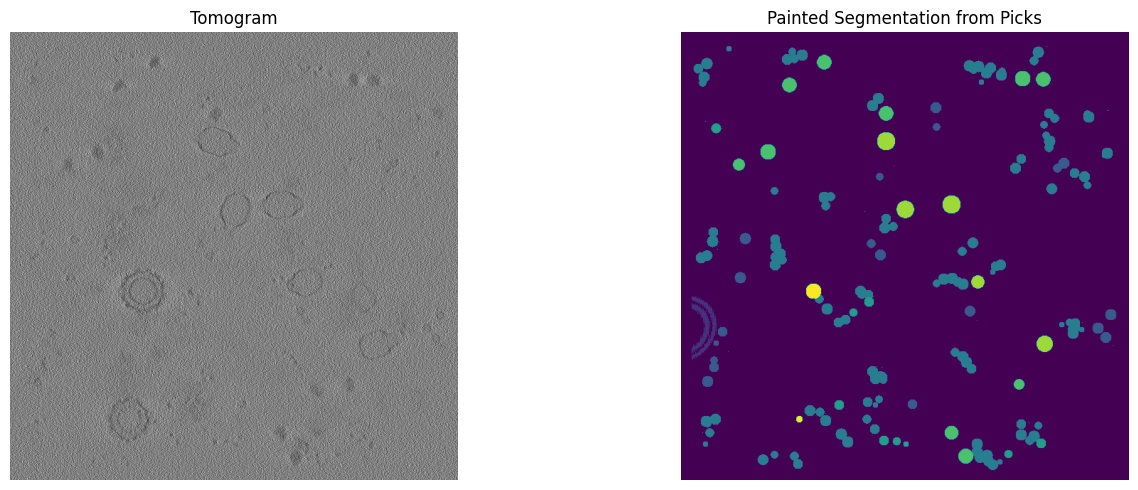

In [5]:
import matplotlib.pyplot as plt

# Plot the images
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.title('Tomogram')
plt.imshow(data_dicts[0]['image'][90],cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Painted Segmentation from Picks')
plt.imshow(data_dicts[0]['label'][90], cmap='viridis')
plt.axis('off')

plt.tight_layout()
plt.show()

### 5. Prepare dataloaders

In [18]:
my_num_samples = 16
train_batch_size = 1
val_batch_size = 1

test_files = data_dicts[-2:]
train_files, val_files = train_test_split(data_dicts[:-2], test_size=0.3)
print(f"Number of training samples: {len(train_files)}")
print(f"Number of validation samples: {len(val_files)}")

# Non-random transforms to be cached
non_random_transforms = Compose([
    EnsureChannelFirstd(keys=["image", "label"], channel_dim="no_channel"),
    NormalizeIntensityd(keys="image"),
    Orientationd(keys=["image", "label"], axcodes="RAS")
])

# Random transforms to be applied during training
random_transforms = Compose([
    RandCropByLabelClassesd(
        keys=["image", "label"],
        label_key="label",
        spatial_size=[96, 96, 96],
        num_classes=8,
        num_samples=my_num_samples
    ),
    RandRotate90d(keys=["image", "label"], prob=0.5, spatial_axes=[0, 2]),
    RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),    
])

# Create the cached dataset with non-random transforms
train_ds = CacheDataset(data=train_files, transform=non_random_transforms, cache_rate=1.0)

# Wrap the cached dataset to apply random transforms during iteration
train_ds = Dataset(data=train_ds, transform=random_transforms)

# DataLoader remains the same
train_loader = DataLoader(
    train_ds,
    batch_size=train_batch_size,
    shuffle=True,
    num_workers=4,
    pin_memory=torch.cuda.is_available()
)

# Validation transforms
val_transforms = Compose([
    EnsureChannelFirstd(keys=["image", "label"], channel_dim="no_channel"),
    NormalizeIntensityd(keys="image"),
    RandCropByLabelClassesd(
        keys=["image", "label"],
        label_key="label",
        spatial_size=[96, 96, 96],
        num_classes=8,
        num_samples=my_num_samples,  # Use 1 to get a single, consistent crop per image
    ),
])

# Create validation dataset
val_ds = CacheDataset(data=val_files, transform=non_random_transforms, cache_rate=1.0)

# Wrap the cached dataset to apply random transforms during iteration
val_ds = Dataset(data=val_ds, transform=random_transforms)

# Create validation DataLoader
val_loader = DataLoader(
    val_ds,
    batch_size=val_batch_size,
    num_workers=4,
    pin_memory=torch.cuda.is_available(),
    shuffle=False,  # Ensure the data order remains consistent
)

Number of training samples: 9
Number of validation samples: 4


Loading dataset: 100%|████████████████████████████| 9/9 [00:02<00:00,  4.14it/s]
/hpc/projects/group.czii/jonathan.schwartz/2024_czii_mlchallenge_notebooks/pyUNET/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Loading dataset: 100%|████████████████████████████| 4/4 [00:00<00:00,  5.88it/s]


## Model setup

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
# Create UNet, DiceLoss and Adam optimizer
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=len(root.pickable_objects)+1,
    channels=(48, 64, 80, 80),
    strides=(2, 2, 1),
    num_res_units=1,
).to(device)

lr = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr)
#loss_function = DiceLoss(include_background=True, to_onehot_y=True, softmax=True)  # softmax=True for multiclass
loss_function = TverskyLoss(include_background=True, to_onehot_y=True, softmax=True)  

dice_metric = DiceMetric(include_background=False, reduction="mean", ignore_empty=True)  # must use onehot for multiclass
recall_metric = ConfusionMatrixMetric(include_background=False, metric_name="recall", reduction="None")

cuda


In [20]:
from monai.inferers import sliding_window_inference

def stack_patches(data):
    shape = data.shape
    new_shape = (shape[0] * shape[1],) + shape[2:]
    return data.view(new_shape)

post_pred = AsDiscrete(argmax=True, to_onehot=len(root.pickable_objects)+1)
post_label = AsDiscrete(to_onehot=len(root.pickable_objects)+1)

def train(train_loader, model, loss_function, metrics_function, optimizer, max_epochs=100):
    val_interval = 2
    best_metric = -1
    best_metric_epoch = -1
    epoch_loss_values = []
    metric_values = []
    for epoch in range(max_epochs):
        print("-" * 10)
        print(f"epoch {epoch + 1}/{max_epochs}")
        model.train()
        epoch_loss = 0
        step = 0
        for batch_data in train_loader:
            step += 1
            inputs = batch_data["image"].to(device)  # Shape: [B, C, H, W, D]
            labels = batch_data["label"].to(device)  # Shape: [B, C, H, W, D]            
            optimizer.zero_grad()
            outputs = model(inputs)    # Output shape: [B, num_classes, H, W, D]
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            print(f"batch {step}/{len(train_ds) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")
        epoch_loss /= step
        epoch_loss_values.append(epoch_loss)
        print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")
        mlflow.log_metric("train_loss", epoch_loss, step=epoch+1)

        if (epoch + 1) % val_interval == 0:
            model.eval()
            with torch.no_grad():
                for val_data in val_loader:
                    val_inputs = val_data["image"].to(device)
                    val_labels = val_data["label"].to(device)
                    val_outputs = model(val_inputs)
                    
                    # Decollate batches into lists
                    val_outputs_list = decollate_batch(val_outputs)
                    val_labels_list = decollate_batch(val_labels)
                    # Apply post-processing
                    metric_val_outputs = [post_pred(i) for i in val_outputs_list]
                    metric_val_labels = [post_label(i) for i in val_labels_list]
                    # Compute metrics
                    metrics_function(y_pred=metric_val_outputs, y=metric_val_labels)

                metrics = metrics_function.aggregate(reduction="mean_batch")
                metric_per_class = ["{:.4g}".format(x) for x in metrics]
                metric = torch.mean(metrics).numpy(force=True)
                mlflow.log_metric("validation metric", metric, step=epoch+1)
                for i,m in enumerate(metrics):
                    mlflow.log_metric(f"validation metric class {i+1}", m, step=epoch+1)
                metrics_function.reset()

                metric_values.append(metric)
                if metric > best_metric:
                    best_metric = metric
                    best_metric_epoch = epoch + 1
                    torch.save(model.state_dict(), os.path.join('./', "best_metric_model.pth"))
                    
                    print("saved new best metric model")
                print(
                    f"current epoch: {epoch + 1} current mean recall per class: {', '.join(metric_per_class)}"
                    f"\nbest mean recall: {best_metric:.4f} "
                    f"at epoch: {best_metric_epoch}"
                )

## Training and tracking

In [21]:
from torchinfo import summary

mlflow.end_run()
mlflow.set_experiment('training 3D U-Net model for the cryoET ML Challenge')
epochs = 200
with mlflow.start_run():
    params = {
        "epochs": epochs,
        "learning_rate": lr,
        "loss_function": loss_function.__class__.__name__,
        "metric_function": recall_metric.__class__.__name__,
        "optimizer": "Adam",
    }
    # Log training parameters.
    mlflow.log_params(params)

    # Log model summary.
    with open("model_summary.txt", "w") as f:
        f.write(str(summary(model)))
    mlflow.log_artifact("model_summary.txt")

    train(train_loader, model, loss_function, dice_metric, optimizer, max_epochs=epochs)

    # Save the trained model to MLflow.
    mlflow.pytorch.log_model(model, "model")


----------
epoch 1/200


/hpc/projects/group.czii/jonathan.schwartz/2024_czii_mlchallenge_notebooks/pyUNET/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


batch 1/9, train_loss: 0.9595
batch 2/9, train_loss: 0.9524
batch 3/9, train_loss: 0.9431
batch 4/9, train_loss: 0.9343
batch 5/9, train_loss: 0.9349
batch 6/9, train_loss: 0.9271
batch 7/9, train_loss: 0.9254
batch 8/9, train_loss: 0.9196
batch 9/9, train_loss: 0.9135
epoch 1 average loss: 0.9344
----------
epoch 2/200
batch 1/9, train_loss: 0.9113
batch 2/9, train_loss: 0.9086
batch 3/9, train_loss: 0.9089
batch 4/9, train_loss: 0.8981
batch 5/9, train_loss: 0.8920
batch 6/9, train_loss: 0.9004
batch 7/9, train_loss: 0.8844
batch 8/9, train_loss: 0.8904
batch 9/9, train_loss: 0.8912
epoch 2 average loss: 0.8984
saved new best metric model
current epoch: 2 current mean recall per class: 0.01426, 0.01126, 0.05382, 0.02512, 0.3477, 0.02237, 0.01565
best mean recall: 0.0700 at epoch: 2
----------
epoch 3/200
batch 1/9, train_loss: 0.8863
batch 2/9, train_loss: 0.8757
batch 3/9, train_loss: 0.8740
batch 4/9, train_loss: 0.8800
batch 5/9, train_loss: 0.8782
batch 6/9, train_loss: 0.8706
ba

batch 7/9, train_loss: 0.7118
batch 8/9, train_loss: 0.7707
batch 9/9, train_loss: 0.7245
epoch 21 average loss: 0.7372
----------
epoch 22/200
batch 1/9, train_loss: 0.7349
batch 2/9, train_loss: 0.7028
batch 3/9, train_loss: 0.7016
batch 4/9, train_loss: 0.7288
batch 5/9, train_loss: 0.6945
batch 6/9, train_loss: 0.7364
batch 7/9, train_loss: 0.8279
batch 8/9, train_loss: 0.6766
batch 9/9, train_loss: 0.7046
epoch 22 average loss: 0.7231
saved new best metric model
current epoch: 22 current mean recall per class: 0.2728, 0.2915, 0.5724, 0.3709, 0.6079, 0, 0
best mean recall: 0.3022 at epoch: 22
----------
epoch 23/200
batch 1/9, train_loss: 0.7037
batch 2/9, train_loss: 0.6643
batch 3/9, train_loss: 0.7214
batch 4/9, train_loss: 0.7065
batch 5/9, train_loss: 0.7052
batch 6/9, train_loss: 0.6736
batch 7/9, train_loss: 0.6901
batch 8/9, train_loss: 0.8317
batch 9/9, train_loss: 0.6908
epoch 23 average loss: 0.7097
----------
epoch 24/200
batch 1/9, train_loss: 0.6806
batch 2/9, train_l

batch 5/9, train_loss: 0.6148
batch 6/9, train_loss: 0.6418
batch 7/9, train_loss: 0.5727
batch 8/9, train_loss: 0.5821
batch 9/9, train_loss: 0.6349
epoch 42 average loss: 0.6355
saved new best metric model
current epoch: 42 current mean recall per class: 0.4158, 0.5585, 0.6038, 0.4913, 0.6093, 0.442, 0.4195
best mean recall: 0.5057 at epoch: 42
----------
epoch 43/200
batch 1/9, train_loss: 0.6312
batch 2/9, train_loss: 0.5575
batch 3/9, train_loss: 0.5901
batch 4/9, train_loss: 0.5855
batch 5/9, train_loss: 0.6540
batch 6/9, train_loss: 0.6441
batch 7/9, train_loss: 0.8147
batch 8/9, train_loss: 0.6386
batch 9/9, train_loss: 0.6412
epoch 43 average loss: 0.6397
----------
epoch 44/200
batch 1/9, train_loss: 0.6054
batch 2/9, train_loss: 0.6153
batch 3/9, train_loss: 0.6041
batch 4/9, train_loss: 0.8106
batch 5/9, train_loss: 0.6262
batch 6/9, train_loss: 0.6239
batch 7/9, train_loss: 0.6096
batch 8/9, train_loss: 0.6001
batch 9/9, train_loss: 0.5779
epoch 44 average loss: 0.6303
sav

current epoch: 62 current mean recall per class: 0.4364, 0.6768, 0.6533, 0.5449, 0.6935, 0.5452, 0.6678
best mean recall: 0.6259 at epoch: 60
----------
epoch 63/200
batch 1/9, train_loss: 0.5275
batch 2/9, train_loss: 0.6188
batch 3/9, train_loss: 0.5714
batch 4/9, train_loss: 0.5491
batch 5/9, train_loss: 0.5985
batch 6/9, train_loss: 0.7722
batch 7/9, train_loss: 0.6131
batch 8/9, train_loss: 0.5728
batch 9/9, train_loss: 0.5708
epoch 63 average loss: 0.5994
----------
epoch 64/200
batch 1/9, train_loss: 0.5391
batch 2/9, train_loss: 0.5611
batch 3/9, train_loss: 0.5615
batch 4/9, train_loss: 0.5368
batch 5/9, train_loss: 0.5463
batch 6/9, train_loss: 0.5700
batch 7/9, train_loss: 0.5643
batch 8/9, train_loss: 0.5806
batch 9/9, train_loss: 0.7930
epoch 64 average loss: 0.5836
current epoch: 64 current mean recall per class: 0.3846, 0.6225, 0.683, 0.5114, 0.7349, 0.583, 0.605
best mean recall: 0.6259 at epoch: 60
----------
epoch 65/200
batch 1/9, train_loss: 0.5593
batch 2/9, train_

batch 3/9, train_loss: 0.5708
batch 4/9, train_loss: 0.5448
batch 5/9, train_loss: 0.5540
batch 6/9, train_loss: 0.5609
batch 7/9, train_loss: 0.4987
batch 8/9, train_loss: 0.5204
batch 9/9, train_loss: 0.5786
epoch 83 average loss: 0.5796
----------
epoch 84/200
batch 1/9, train_loss: 0.5565
batch 2/9, train_loss: 0.7522
batch 3/9, train_loss: 0.5335
batch 4/9, train_loss: 0.5430
batch 5/9, train_loss: 0.5297
batch 6/9, train_loss: 0.5578
batch 7/9, train_loss: 0.5707
batch 8/9, train_loss: 0.5339
batch 9/9, train_loss: 0.5615
epoch 84 average loss: 0.5710
current epoch: 84 current mean recall per class: 0.375, 0.6793, 0.6945, 0.5822, 0.7528, 0.6395, 0.6942
best mean recall: 0.6590 at epoch: 74
----------
epoch 85/200
batch 1/9, train_loss: 0.5768
batch 2/9, train_loss: 0.5668
batch 3/9, train_loss: 0.7643
batch 4/9, train_loss: 0.5265
batch 5/9, train_loss: 0.5742
batch 6/9, train_loss: 0.5401
batch 7/9, train_loss: 0.5856
batch 8/9, train_loss: 0.5514
batch 9/9, train_loss: 0.5638
e

batch 1/9, train_loss: 0.5658
batch 2/9, train_loss: 0.5479
batch 3/9, train_loss: 0.5737
batch 4/9, train_loss: 0.5468
batch 5/9, train_loss: 0.5517
batch 6/9, train_loss: 0.5477
batch 7/9, train_loss: 0.7592
batch 8/9, train_loss: 0.5474
batch 9/9, train_loss: 0.5447
epoch 104 average loss: 0.5761
current epoch: 104 current mean recall per class: 0.402, 0.6984, 0.7199, 0.6066, 0.7508, 0.7179, 0.7442
best mean recall: 0.6770 at epoch: 96
----------
epoch 105/200
batch 1/9, train_loss: 0.5314
batch 2/9, train_loss: 0.5671
batch 3/9, train_loss: 0.5382
batch 4/9, train_loss: 0.5862
batch 5/9, train_loss: 0.7727
batch 6/9, train_loss: 0.5259
batch 7/9, train_loss: 0.5446
batch 8/9, train_loss: 0.5507
batch 9/9, train_loss: 0.5405
epoch 105 average loss: 0.5730
----------
epoch 106/200
batch 1/9, train_loss: 0.5041
batch 2/9, train_loss: 0.4952
batch 3/9, train_loss: 0.5203
batch 4/9, train_loss: 0.5245
batch 5/9, train_loss: 0.7431
batch 6/9, train_loss: 0.5509
batch 7/9, train_loss: 0.5

batch 8/9, train_loss: 0.5255
batch 9/9, train_loss: 0.7591
epoch 124 average loss: 0.5586
current epoch: 124 current mean recall per class: 0.4687, 0.6566, 0.7426, 0.6855, 0.7372, 0.6864, 0.849
best mean recall: 0.6917 at epoch: 118
----------
epoch 125/200
batch 1/9, train_loss: 0.5545
batch 2/9, train_loss: 0.5260
batch 3/9, train_loss: 0.5496
batch 4/9, train_loss: 0.5393
batch 5/9, train_loss: 0.5020
batch 6/9, train_loss: 0.5693
batch 7/9, train_loss: 0.7471
batch 8/9, train_loss: 0.5293
batch 9/9, train_loss: 0.5315
epoch 125 average loss: 0.5610
----------
epoch 126/200
batch 1/9, train_loss: 0.5225
batch 2/9, train_loss: 0.4848
batch 3/9, train_loss: 0.5341
batch 4/9, train_loss: 0.5514
batch 5/9, train_loss: 0.7551
batch 6/9, train_loss: 0.5203
batch 7/9, train_loss: 0.4726
batch 8/9, train_loss: 0.5154
batch 9/9, train_loss: 0.5496
epoch 126 average loss: 0.5451
current epoch: 126 current mean recall per class: 0.3911, 0.639, 0.7482, 0.6221, 0.726, 0.6839, 0.8175
best mean r

batch 1/9, train_loss: 0.5151
batch 2/9, train_loss: 0.5038
batch 3/9, train_loss: 0.5507
batch 4/9, train_loss: 0.5272
batch 5/9, train_loss: 0.5172
batch 6/9, train_loss: 0.5655
batch 7/9, train_loss: 0.5187
batch 8/9, train_loss: 0.7434
batch 9/9, train_loss: 0.5524
epoch 145 average loss: 0.5549
----------
epoch 146/200
batch 1/9, train_loss: 0.5463
batch 2/9, train_loss: 0.5485
batch 3/9, train_loss: 0.5242
batch 4/9, train_loss: 0.4886
batch 5/9, train_loss: 0.5407
batch 6/9, train_loss: 0.5384
batch 7/9, train_loss: 0.5191
batch 8/9, train_loss: 0.7325
batch 9/9, train_loss: 0.5512
epoch 146 average loss: 0.5544
saved new best metric model
current epoch: 146 current mean recall per class: 0.3873, 0.7763, 0.7841, 0.664, 0.764, 0.6545, 0.8365
best mean recall: 0.6952 at epoch: 146
----------
epoch 147/200
batch 1/9, train_loss: 0.5668
batch 2/9, train_loss: 0.7493
batch 3/9, train_loss: 0.5496
batch 4/9, train_loss: 0.5211
batch 5/9, train_loss: 0.5174
batch 6/9, train_loss: 0.555

batch 7/9, train_loss: 0.4952
batch 8/9, train_loss: 0.5808
batch 9/9, train_loss: 0.5122
epoch 165 average loss: 0.5432
----------
epoch 166/200
batch 1/9, train_loss: 0.4935
batch 2/9, train_loss: 0.5303
batch 3/9, train_loss: 0.5286
batch 4/9, train_loss: 0.5050
batch 5/9, train_loss: 0.5263
batch 6/9, train_loss: 0.7630
batch 7/9, train_loss: 0.5143
batch 8/9, train_loss: 0.5204
batch 9/9, train_loss: 0.5590
epoch 166 average loss: 0.5489
current epoch: 166 current mean recall per class: 0.4422, 0.7512, 0.7167, 0.5841, 0.7937, 0.7224, 0.849
best mean recall: 0.7094 at epoch: 160
----------
epoch 167/200
batch 1/9, train_loss: 0.5191
batch 2/9, train_loss: 0.5437
batch 3/9, train_loss: 0.4695
batch 4/9, train_loss: 0.5017
batch 5/9, train_loss: 0.4828
batch 6/9, train_loss: 0.5529
batch 7/9, train_loss: 0.4837
batch 8/9, train_loss: 0.7421
batch 9/9, train_loss: 0.5175
epoch 167 average loss: 0.5348
----------
epoch 168/200
batch 1/9, train_loss: 0.5254
batch 2/9, train_loss: 0.5673

batch 4/9, train_loss: 0.5270
batch 5/9, train_loss: 0.5189
batch 6/9, train_loss: 0.5294
batch 7/9, train_loss: 0.5499
batch 8/9, train_loss: 0.7374
batch 9/9, train_loss: 0.5053
epoch 186 average loss: 0.5548
current epoch: 186 current mean recall per class: 0.3321, 0.752, 0.7677, 0.651, 0.7319, 0.7082, 0.7978
best mean recall: 0.7153 at epoch: 174
----------
epoch 187/200
batch 1/9, train_loss: 0.5819
batch 2/9, train_loss: 0.4861
batch 3/9, train_loss: 0.4873
batch 4/9, train_loss: 0.5143
batch 5/9, train_loss: 0.7264
batch 6/9, train_loss: 0.4884
batch 7/9, train_loss: 0.5040
batch 8/9, train_loss: 0.5530
batch 9/9, train_loss: 0.5216
epoch 187 average loss: 0.5403
----------
epoch 188/200
batch 1/9, train_loss: 0.5232
batch 2/9, train_loss: 0.5464
batch 3/9, train_loss: 0.5451
batch 4/9, train_loss: 0.7601
batch 5/9, train_loss: 0.5311
batch 6/9, train_loss: 0.5243
batch 7/9, train_loss: 0.5394
batch 8/9, train_loss: 0.5192
batch 9/9, train_loss: 0.5242
epoch 188 average loss: 0.

2024/10/02 00:37:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


##### Let's Go Straight to Evaluating the Model

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=len(root.pickable_objects)+1,
    channels=(48, 64, 80, 80),
    strides=(2, 2, 1),
    num_res_units=1,
).to(device)

model.load_state_dict(torch.load("best_metric_model.pth", weights_only=True))

cuda


<All keys matched successfully>

In [23]:
def inference(model, input):
    def _compute(input):
        return sliding_window_inference(
            inputs=input,
            roi_size=(96, 96, 96),
            sw_batch_size=4,  # one window is proecessed at a time
            predictor=model,
            overlap=0.5,
        )

    with torch.cuda.amp.autocast():
        return _compute(input)

In [25]:
# define pre transforms
pre_transforms = Compose(
    [   EnsureChannelFirstd(keys=["image"], channel_dim="no_channel"),
        NormalizeIntensityd(keys=["image"]),
])


test_ds = CacheDataset(data=test_files, transform=pre_transforms)
test_loader = DataLoader(test_ds, 
                         batch_size=4, 
                         shuffle=False, 
                         num_workers=4, 
                         pin_memory=torch.cuda.is_available())

Loading dataset: 100%|████████████████████████████| 2/2 [00:02<00:00,  1.48s/it]


In [27]:
from monai.data import decollate_batch
from tqdm import tqdm
from monai.transforms import (
    Compose, 
    NormalizeIntensityd,
    EnsureChannelFirstd, 
    ScaleIntensityRanged, 
    Orientationd,  
    Resized, 
    Activationsd,
    Invertd,
    AsDiscreted
)

post_transforms = Compose([
            Activationsd(keys="pred", softmax=True),
            AsDiscreted(keys="pred", argmax=True)
])

predictions = []
with torch.no_grad():
    for data in tqdm(test_loader):
        tomogram = data['image'].to(device)  # only support batch=1 and channel first
        data["pred"] = inference(model, tomogram)
        data = [post_transforms(i) for i in decollate_batch(data)]
        for b in data:
            predictions.append(b['pred'].squeeze(0).numpy(force=True))

  0%|                                                     | 0/1 [00:00<?, ?it/s]/tmp/ipykernel_1119924/339001617.py:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|█████████████████████████████████████████████| 1/1 [00:19<00:00, 19.87s/it]


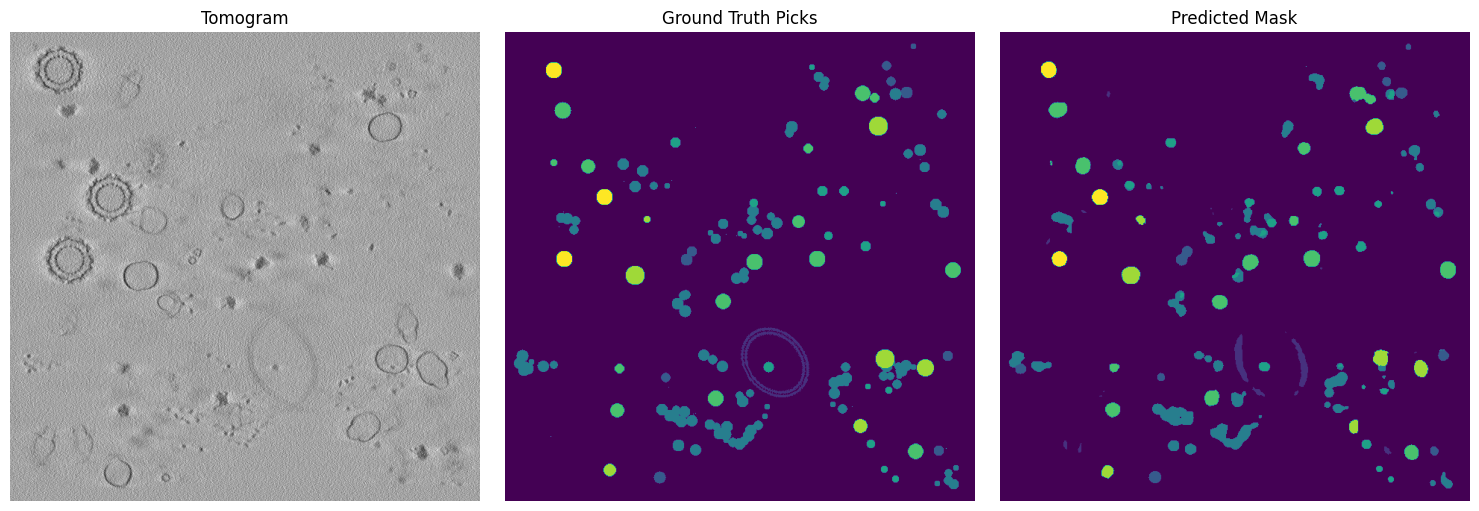

In [29]:
import matplotlib.pyplot as plt

tomo_index = 0

# Plot the images
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title('Tomogram')
plt.imshow(test_files[tomo_index]['image'][60], cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Ground Truth Picks')
plt.imshow(test_files[tomo_index]['label'][60], cmap='viridis')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Predicted Mask')
plt.imshow(predictions[tomo_index][60],cmap='viridis')
plt.axis('off')

plt.tight_layout()
plt.show()